In [20]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import *
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pylab
import scipy.stats as stats
import json
%matplotlib inline

In [21]:
data = pd.read_csv('../data/nyc/nyc_clean.csv')
data.head()

,id,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,availability_365,reviews_per_month,Allerton,...,40-49,50-59,60-69,70-79,80-84,85-89,90-94,95-100,No Reviews,price
0,3647,-0.463733,-0.350426,-0.434441,-0.554131,-0.999749,-0.199282,1.919840,-0.693829,0,...,0,0,0,0,0,0,0,0,1,150.0
1,3831,0.103814,-0.350426,-0.434441,2.345690,1.670560,-0.295507,0.606257,2.106322,0,...,0,0,0,0,0,0,1,0,0,89.0
2,5099,-0.463733,-0.350426,-0.434441,-0.554131,0.088155,-0.199282,-0.752884,-0.336234,0,...,0,0,0,0,0,1,0,0,0,200.0
3,5178,-0.463733,-0.350426,-0.434441,-0.554131,-0.109646,-0.247394,1.016277,1.433559,0,...,0,0,0,0,1,0,0,0,0,79.0
4,5203,-1.031279,-0.350426,-0.434441,-0.554131,0.187055,-0.247394,-0.851593,-0.105918,0,...,0,0,0,0,0,0,0,1,0,79.0


In [23]:
x = data.iloc[:, 1:-1]
y = data.iloc[:, -1]


In [25]:
# helper function for plotting residual plots
def plot_residual(ax1, ax2, ax3, y_pred, y_real, line_label, title):
    ax1.scatter(y_pred,
                y_real,
                color='blue',
                alpha=0.6,
                label=line_label)
    ax1.set_xlabel('Predicted Y')
    ax1.set_ylabel('Real Y')
    ax1.legend(loc='best')
    ax1.set_title(title)

    ax2.scatter(y_pred,
                y_real - y_pred,
                color='green',
                marker='x',
                alpha=0.6,
                label='Residual')
    ax2.set_xlabel('Predicted Y')
    ax2.set_ylabel('Residual')

    ax2.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')

    ax2.legend(loc='best')
    ax2.set_title('Residual Plot')

    ax3.hist(y_real - y_pred, bins=30, color='green', alpha=0.7)
    ax3.set_title('Histogram of residual values')

    return ax1, ax2, ax3

In [24]:
class model:

    def __init__(self, model):
        self.model = model
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.y_pred_train = None
        self.y_pred_test = None
        self.train_score = None
        self.test_score = None
        self.train_score_log = None
        self.test_score_log = None

    def data_split(self, x, y, test_size):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=test_size)

    def score_reg(self):
        return self.train_score, self.test_score

    def score_log(self):
        self.train_score_log = metrics.r2_score(np.exp(self.y_train), np.exp(self.y_pred_train))
        self.test_score_log = metrics.r2_score(np.exp(self.y_test), np.exp(self.y_pred_test))
        return self.train_score_log, self.test_score_log

    def data_frame_convert(self):
        df_train = pd.DataFrame({'y_pred': self.y_pred_train, 'y_real': self.y_train})
        df_test = pd.DataFrame({'y_pred_test': self.y_pred_test, 'y_real_test': self.y_test})
        return self.train_score, self.test_score, df_train, df_test

    def data_frame_convert_log(self):
        df_train = pd.DataFrame({'y_pred': np.exp(self.y_pred_train), 'y_real': np.exp(self.y_train)})
        df_test = pd.DataFrame({'y_pred_test': np.exp(self.y_pred_test), 'y_real_test': np.exp(self.y_test)})
        return self.train_score_log, self.test_score_log, df_train, df_test

    def fit_model(self, x, y, test_size):
        self.data_split(x, y, test_size)
        self.model = self.model.fit(self.x_train, self.y_train)
        self.train_score = self.model.score(self.x_train, self.y_train)
        self.test_score = self.model.score(self.x_test, self.y_test)
        self.y_pred_train = self.model.predict(self.x_train)
        print(self.x_train.shape[1])
#         print(self.y_pred_train)
#         print(type(self.y_train))
        self.y_pred_test = self.model.predict(self.x_test)
#         print(self.y_pred_train)

    def predict_helper(self, x):
        return self.model.predict(x)
        
def model_iterations(n, x, y, model_arg, log_bool=False):
    training_scores = [None]*n
    testing_scores = [None]*n

    for i in range(n):
        new_model = model(model_arg)
        new_model.fit_model(x, y, 0.3)
        training_scores[i], testing_scores[i] = new_model.score_reg() if not log_bool else new_model.score_log()

    print('Mean Train Score:', np.mean(training_scores))
    print('Mean Test Score:', np.mean(testing_scores))
    return new_model

def predict(x_to_predict, n, x, y, model_arg, log_bool=False):
    new_model = model(model_arg)
    new_model.fit_model(x, y, 0.3)
    y_predict = new_model.predict_helper(x_to_predict)
#     print("predict price:")
    return y_predict
    

In [26]:
# print(y)
Lin_Reg_Model = model_iterations(1, x, y, Lin_Reg(fit_intercept=True))


284
Mean Train Score: 0.6324387551430692
Mean Test Score: -2902080521857654.0


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def to_predict(x_input, columns_str):
    hh  = '{"accommodates": {"mean": 2.817083363182654, "std": 1.761970738437282}, "bedrooms": {"mean": 1.2673066361009624, "std": 0.6152880622623258}, "bathrooms": {"mean": 1.1422499223917664, "std": 0.4059347097370321}, "beds": {"mean": 1.5732741122812044, "std": 1.0345467570567484}, "amenities": {"mean": 21.108651527091244, "std": 10.111189797545686}, "reviews_per_month": {"mean": 1.1447558325572713, "std": 1.6499110482795671}, "availability_365": {"mean": 112.15545526183824, "std": 131.7008456107491}, "minimum_nights": {"mean": 7.141987248370227, "std": 20.78460379915744}}'
    standardize_dict = json.loads(hh)
    x_input = {"accommodates":2, "bathrooms": 1, "bedrooms": 1,"beds": 1, "amenities":15, "minimum_nights": 3, "availability_365":365, "reviews_per_month":0,
              "neighbourhood_cleansed": "Harlem",
               "room_type": "Private room",
               "host_is_superhost":"f",
               "bed_type":"Pull-out Sofa",
               "review_scores_rating": 90,
               "property_type": "Apartment"

              }
    columns_str = "accommodates	bathrooms	bedrooms	beds	amenities	minimum_nights	availability_365	reviews_per_month	Allerton	Arden Heights	Arrochar	Arverne	Astoria	Bath Beach	Battery Park City	Bay Ridge	Bay Terrace	Bay Terrace, Staten Island	Baychester	Bayside	Bayswater	Bedford-Stuyvesant	Belle Harbor	Bellerose	Belmont	Bensonhurst	Bergen Beach	Boerum Hill	Borough Park	Breezy Point	Briarwood	Brighton Beach	Bronxdale	Brooklyn Heights	Brownsville	Bull's Head	Bushwick	Cambria Heights	Canarsie	Carroll Gardens	Castle Hill	Castleton Corners	Chelsea	Chinatown	City Island	Civic Center	Claremont Village	Clason Point	Clifton	Clinton Hill	Co-op City	Cobble Hill	College Point	Columbia St	Concord	Concourse	Concourse Village	Coney Island	Corona	Country Club	Crown Heights	Cypress Hills	DUMBO	Ditmars Steinway	Dongan Hills	Douglaston	Downtown Brooklyn	Dyker Heights	East Elmhurst	East Flatbush	East Harlem	East Morrisania	East New York	East Village	Eastchester	Edenwald	Edgemere	Elmhurst	Eltingville	Emerson Hill	Far Rockaway	Fieldston	Financial District	Flatbush	Flatiron District	Flatlands	Flushing	Fordham	Forest Hills	Fort Greene	Fort Hamilton	Fresh Meadows	Gerritsen Beach	Glendale	Gowanus	Gramercy	Graniteville	Grant City	Gravesend	Great Kills	Greenpoint	Greenwich Village	Grymes Hill	Harlem	Hell's Kitchen	Highbridge	Hollis	Holliswood	Howard Beach	Howland Hook	Huguenot	Hunts Point	Inwood	Jackson Heights	Jamaica	Jamaica Estates	Jamaica Hills	Kensington	Kew Gardens	Kew Gardens Hills	Kingsbridge	Kips Bay	Laurelton	Lighthouse Hill	Little Italy	Little Neck	Long Island City	Longwood	Lower East Side	Manhattan Beach	Marble Hill	Mariners Harbor	Maspeth	Melrose	Middle Village	Midland Beach	Midtown	Midwood	Mill Basin	Morningside Heights	Morris Heights	Morris Park	Morrisania	Mott Haven	Mount Eden	Mount Hope	Murray Hill	Navy Yard	Neponsit	New Brighton	New Dorp Beach	New Springville	NoHo	Nolita	North Riverdale	Norwood	Oakwood	Olinville	Ozone Park	Park Slope	Parkchester	Pelham Bay	Pelham Gardens	Port Morris	Port Richmond	Prince's Bay	Prospect Heights	Prospect-Lefferts Gardens	Queens Village	Randall Manor	Red Hook	Rego Park	Richmond Hill	Richmondtown	Ridgewood	Riverdale	Rockaway Beach	Roosevelt Island	Rosebank	Rosedale	Rossville	Schuylerville	Sea Gate	Sheepshead Bay	Shore Acres	Silver Lake	SoHo	Soundview	South Beach	South Ozone Park	South Slope	Springfield Gardens	Spuyten Duyvil	St. Albans	St. George	Stapleton	Stuyvesant Town	Sunnyside	Sunset Park	Theater District	Throgs Neck	Todt Hill	Tompkinsville	Tottenville	Tremont	Tribeca	Two Bridges	Unionport	University Heights	Upper East Side	Upper West Side	Van Nest	Vinegar Hill	Wakefield	Washington Heights	West Brighton	West Farms	West Village	Westchester Square	Westerleigh	Whitestone	Williamsbridge	Williamsburg	Willowbrook	Windsor Terrace	Woodhaven	Woodlawn	Woodside	Aparthotel	Apartment	Barn	Bed and breakfast	Boat	Boutique hotel	Bungalow	Cabin	Camper/RV	Casa particular (Cuba)	Castle	Cave	Condominium	Cottage	Dome house	Earth house	Farm stay	Guest suite	Guesthouse	Hostel	Hotel	House	Houseboat	Loft	Nature lodge	Other	Resort	Serviced apartment	Tent	Timeshare	Tiny house	Townhouse	Villa	Yurt	Entire home/apt	Hotel room	Private room	Shared room	f	t	Airbed	Couch	Futon	Pull-out Sofa	Real Bed	20-29	30-39	40-49	50-59	60-69	70-79	80-84	85-89	90-94	95-100	No Reviews"
    columns_list = columns_str.split("\t")

    x_to_predict = ["0"] * len(columns_list)

    for i in range(0, 8):
        mean = standardize_dict[columns_list[i]]["mean"]
        std = standardize_dict[columns_list[i]]["std"]

        x_to_predict[i] = str(round(((x_input[columns_list[i]]) - mean) / std, 9))
        
    x_to_predict[columns_list.index(x_input["neighbourhood_cleansed"])] = "1"
    x_to_predict[columns_list.index(x_input["room_type"])] = "1"
    x_to_predict[columns_list.index(x_input["bed_type"])] = "1"
    x_to_predict[columns_list.index(x_input["property_type"])] = "1"
    x_to_predict[columns_list.index(x_input["host_is_superhost"])] = "1"
    if "review_scores_rating" in x_input:
        x_to_predict[columns_list.index(convert_scores_buckets(x_input["review_scores_rating"]))] = "1"
    else:
        x_to_predict[-1] = '1'

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

    xgb_reg = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)
    xgb_reg.fit(X_train, y_train)
    test = pd.DataFrame([x_to_predict], columns =columns_list)
    for column in columns_list:
        test[column] = pd.to_numeric(test[column])

    training_preds_xgb_reg = xgb_reg.predict(X_train)
    val_preds_xgb_reg = xgb_reg.predict(X_test)
    print(training_preds_xgb_reg)

    print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
    print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
    print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
    print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))
#     x_df = pd.DataFrame([x_to_predict], columns =columns_list) 
#     return predict(x_df, 1, x, y, Lin_Reg(fit_intercept=True))

# to_predict(1,2)

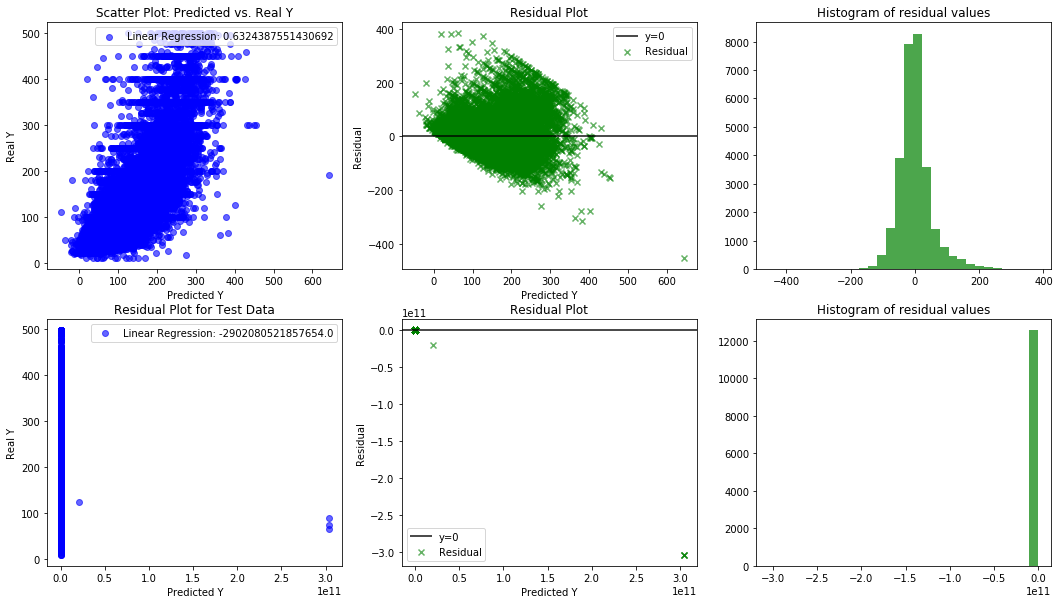

In [29]:
# plot the residuals of a linear regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_vals = Lin_Reg_Model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], data_vals[2]['y_pred'], data_vals[2]['y_real'], 'Linear Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], data_vals[3]['y_pred_test'], data_vals[3]['y_real_test'], 'Linear Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()
# print(data_vals[2]['y_pred'])
# print(data_vals[2]['y_real'])

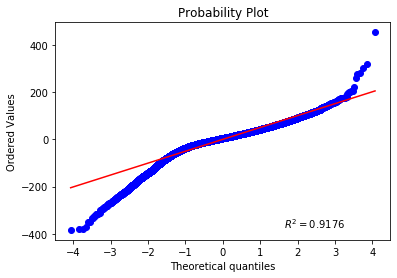

In [32]:
# qq plot for the train residuals
stats.probplot(data_vals[2]['y_pred'] - data_vals[2]['y_real'], dist="norm", plot=pylab, rvalue = True)
pylab.show()

In [33]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(2, x, y, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5))

284
284
Mean Train Score: 0.6291481107894175
Mean Test Score: 0.6250978513946104


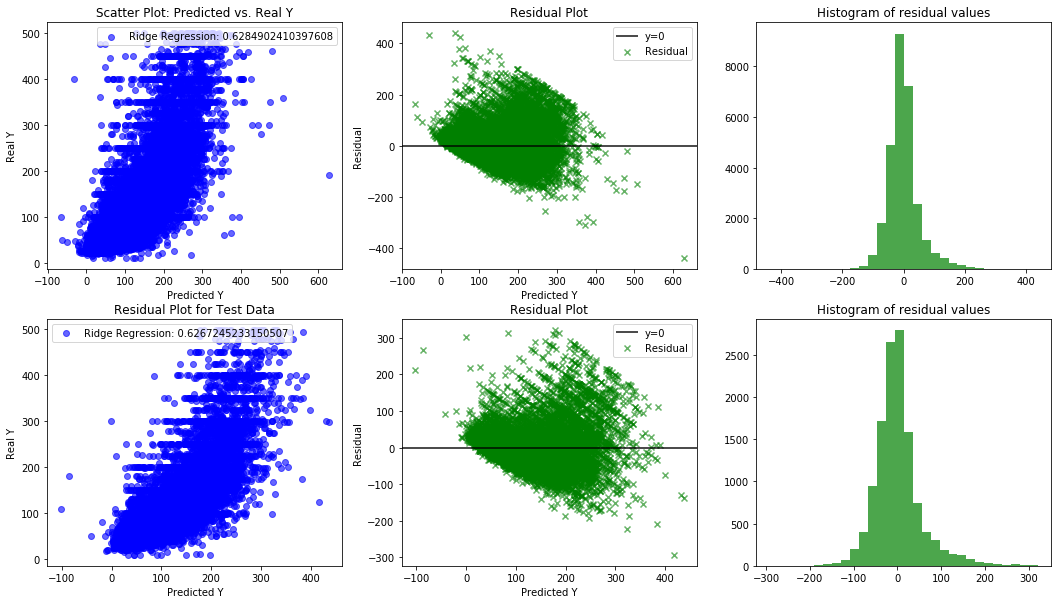

In [34]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

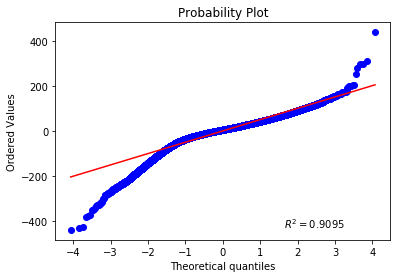

In [35]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab, rvalue = True)
pylab.show()

In [38]:
LassoCV_model = model_iterations(2, x, y, LassoCV(alphas=reg_params, fit_intercept=True, cv=5))

/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29022.211188286543, tolerance: 17811.715047424306
  tol, rng, random, positive)
/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28960.892248287797, tolerance: 17811.715047424306
  tol, rng, random, positive)
/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28961.50120410323, tolerance: 17811.715047424306
  tol, rng, random, positive)
/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471:

284


/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42188.09521125257, tolerance: 17622.43430417484
  tol, rng, random, positive)
/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7363397.3041483015, tolerance: 17622.43430417484
  tol, rng, random, positive)
/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7362572.791320242, tolerance: 17622.43430417484
  tol, rng, random, positive)
/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Con

284
Mean Train Score: 0.630652261590952
Mean Test Score: 0.6219605529481448


/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9018782.181111537, tolerance: 21969.46655296285
  positive)


24.79296875
24.75771102107401
29.912321548330674
37.32117325193617
24.679785535243738
26.366297188548167
[19:43:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


21.104141235351562


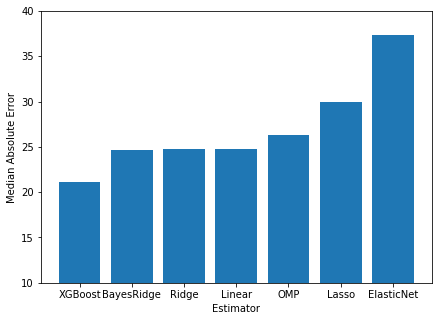

/Users/zhangxinyan/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:45:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
       accommodates  bathrooms  bedrooms      beds  amenities  minimum_nights  \
1223       0.103814  -0.350426 -0.434441  1.379083   1.176058       -0.151169   
38875      4.076638  -0.350426  1.190814  2.345690   2.263962       -0.247394   
204        0.671360  -0.350426  1.190814  1.379083  -1.098649       -0.247394   
24159     -0.463733  -0.350426 -0.434441 -0.554131  -1.098649       -0.295507   
19624      0.103814  -0.350426 -0.434441 -0.554131  -0.900849       -0.247394   
30672      1.238906  -0.350426  1.190814  0.412476  -0.999749       -0.295507   
3572       0.103814  -0.350426 -0.434441 -0.554131  -0.900849       -0.199282   
40167      1.238906  -0.350426  1.190814  0.412476  -0.307447       -0.199282   
27153      0.103814   2.113025 -0.434441 -0.554131   0.780457       -0.199282   
21116     -1.031279  -0.350426 -0.434441 -0.554131  -0.900849       -0.295

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)
import xgboost as xgb
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit(),xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4) ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP',"XGBoost"])
errvals = np.array([])

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    print(this_err)
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.ylim((10,40))

plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
plt.show()

# Fitting the model
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)
print(X_train)
# Printing the results
print("\nTraining MSE:", round(median_absolute_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(median_absolute_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

# # Producing a dataframe of feature importances
# ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
# ft_weights_xgb_reg.sort_values('weight', inplace=True)


In [46]:
from sklearn import ensemble

n_est = 300

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1.0 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters, scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='lad', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=1.0,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Text(0, 0.5, 'Least Absolute Deviation')

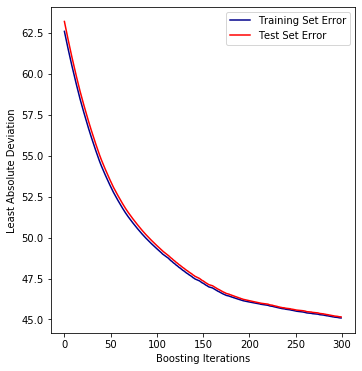

In [47]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

Text(0.5, 1.0, 'Variable Importance')

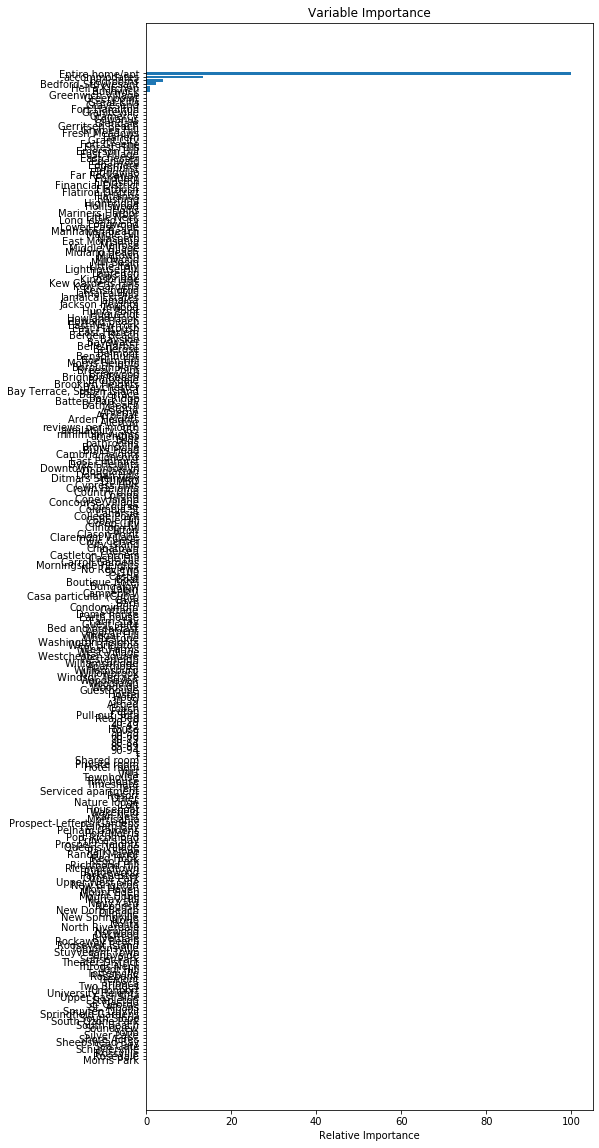

In [48]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,20))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')